In [26]:
import cv2
import numpy as np
import math as m
from random import *
import matplotlib.pyplot as plt

In [27]:
i = 4

img_path = f"./IMG_{i}.jpeg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

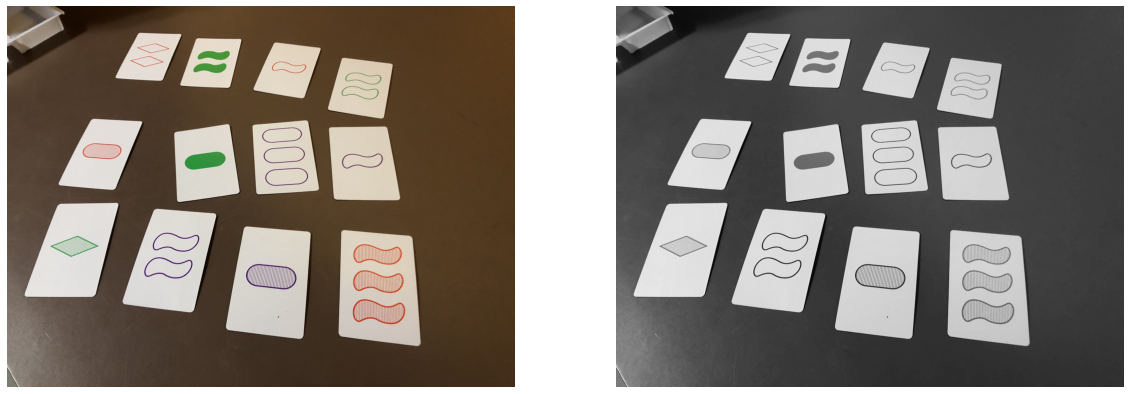

In [28]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")
plt.axis("off")
plt.show()

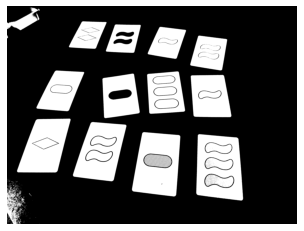

In [29]:
#threshold the image
ret, thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap="gray")
plt.axis("off")
plt.show()

In [30]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# get area of the 12th largest contour
cnt = sorted(contours, key=cv2.contourArea, reverse=True)[11]

# only keep contours within 5% of the 12th largest contour
contours = [c for c in contours if cv2.contourArea(c) > 0.90 * cv2.contourArea(cnt)]

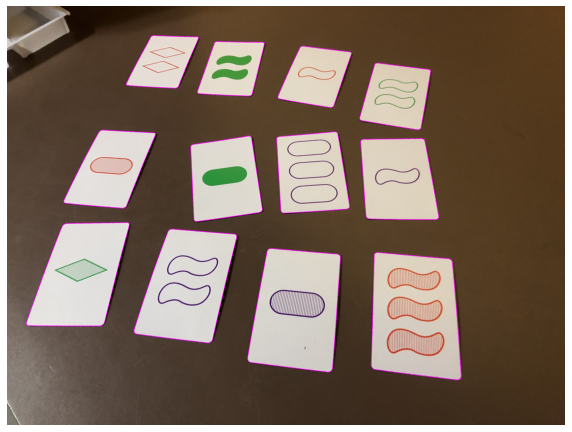

In [31]:
# draw contours
img_contours = img.copy()
img_contours = cv2.drawContours(img_contours, contours, -1, (255, 0, 255), 3)
plt.figure(figsize=(10, 10))
plt.imshow(img_contours)
plt.axis("off")
plt.show()

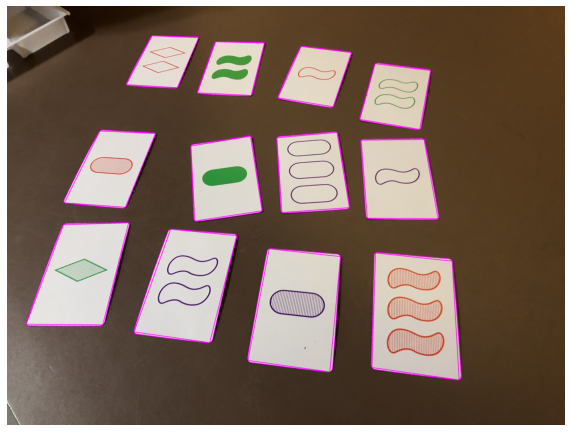

In [32]:
boxes = []
for c in contours:
    # approximate contour as a rectangle using approxPolyDP
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if(approx.shape != (4, 1, 2)):
        continue

    boxes.append(approx)


# draw contours
img_contours = cv2.drawContours(img_contours, boxes, -1, (255, 0, 255), 3)
plt.figure(figsize=(10, 10))
plt.imshow(img_contours)
plt.axis("off")
plt.show()

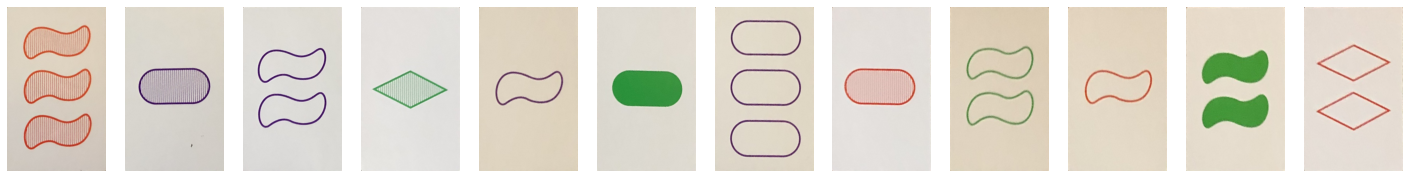

In [33]:
# use the box to warp perspective
warp_size = (300, 500)
cards = []
for box in boxes:
    pts = np.array(box, dtype="float32")
    pts = pts.reshape((4, 2))

    top_left = pts[np.argmin(pts[:, 0] + pts[:, 1])]
    bottom_right = pts[np.argmax(pts[:, 0] + pts[:, 1])]
    bottom_left = pts[np.argmax(pts[:, 0] - pts[:, 1])]
    top_right = pts[np.argmax(pts[:, 1] - pts[:, 0])]

    pts = np.array([top_left, top_right, bottom_right, bottom_left], dtype="float32")
    
    pts2 = np.float32([[0, 0], [0, warp_size[1]], [warp_size[0], warp_size[1]], [warp_size[0], 0]])
    M = cv2.getPerspectiveTransform(pts, pts2)
    warped = cv2.warpPerspective(img, M, warp_size)
    cards.append(warped)
    
# plot all cards
plt.figure(figsize=(25, 25))
for i, card in enumerate(cards):
    plt.subplot(1, len(cards), i + 1)
    plt.imshow(card)
    plt.axis("off")
plt.show()

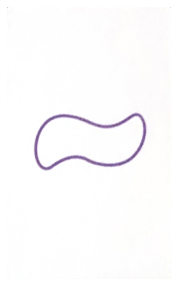

In [41]:
def white_balance(card):
    card = card.copy()

    average_pixel = (card[0:50] / 2 + card[450:500] / 2)
    average_pixel = np.average(average_pixel, axis=0)
    average_pixel = np.average(average_pixel, axis=0)

    # correction to make the average background pixel totally white
    correction = [255,255,255] - average_pixel

    card = card.astype(np.uint16)
    correction = correction.astype(np.uint16)

    # get card height and width
    h,w,_ = card.shape

    correction = np.repeat([correction], w, axis=0)
    correction = np.repeat([correction], h, axis=0)

    card = card + correction
    card = np.clip(card, 0, 255)
    card = card.astype(np.uint8)
    return card

card_test = white_balance(cards[4])

plt.figure(figsize=(5, 5))
plt.imshow(card_test)
plt.axis("off")
plt.show()

In [ ]:
def get_card_color(card):
    card_hsv = card.copy()
    card_hsv = cv2.cvtColor(card_hsv, cv2.COLOR_RGB2HSV)

    card_saturated = card_hsv[:, :, 1] > np.average(card_hsv[:, :, 1]) * 2

    # get the average color of the card in saturated areas
    avg_color = np.average(card_hsv[card_saturated], axis=0)

    hue = avg_color[0]

    if hue > 120 and hue < 160:
        return "purple"
    elif hue > 45 and hue < 80:
        return "green"
    elif hue > 160 or hue < 45:
        return "red"
    else:
        return "unknown"

In [ ]:
# print each card and its color
plt.figure(figsize=(25, 25))
for i, card in enumerate(cards):
    plt.subplot(1, len(cards), i + 1)
    plt.imshow(card)
    plt.axis("off")
    print(f"Card {i}: {get_card_color(card)}")
plt.show()

In [ ]:
def dilate(mask, morph_size=3, iterations=1):
    morph_kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_size, morph_size))

    mask = cv2.dilate(mask, morph_kern, iterations=iterations)
    return mask


def erode(mask, morph_size=3, iterations=1):
    morph_kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_size, morph_size))

    mask = cv2.erode(mask, morph_kern, iterations=iterations)
    return mask

In [ ]:
def get_num_shapes(card):
    card = card.copy()

    # blur the card
    card = cv2.GaussianBlur(card, (11,11), 0)

    # edge detection
    edges = cv2.Canny(card, 50, 100)

    edges = dilate(edges, iterations=10)

    # show edges
    # plt.figure(figsize=(5,5))
    # plt.imshow(img_contours, cmap="gray")
    # plt.imshow(edges)
    # plt.axis("off")
    # plt.show()

    # use opencv simple blob detector
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 3000
    params.maxArea = 25000
    params.filterByCircularity = False
    params.filterByConvexity = False
    params.filterByInertia = False

    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(edges)

    # print area of each blob
    # for k in keypoints:
    #     print(f"Area: {k.size}")

    # show the keypoints
    # img_keypoints = cv2.drawKeypoints(card, keypoints, np.array([]), (0, 255, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # plt.figure(figsize=(5,5))
    # plt.imshow(img_keypoints)
    # plt.axis("off")
    # plt.show()

    return len(keypoints)

In [ ]:
def get_shape_and_num_shapes(card):
    card = card.copy()

    # blur the card
    card = cv2.GaussianBlur(card, (11,11), 0)

    # edge detection
    edges = cv2.Canny(card, 50, 100)

    edges_dilate = dilate(edges, iterations=10)

    # show edges
    # plt.figure(figsize=(5,5))
    # plt.imshow(img_contours, cmap="gray")
    # plt.imshow(edges)
    # plt.axis("off")
    # plt.show()

    # use opencv simple blob detector
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 3000
    params.maxArea = 25000
    params.filterByCircularity = False
    params.filterByConvexity = False
    params.filterByInertia = False

    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(edges_dilate)

    centers = [k.pt for k in keypoints]

    # print area of each blob
    # for k in keypoints:
    #     print(f"Area: {k.size}")

    # show the keypoints
    # img_keypoints = cv2.drawKeypoints(card, keypoints, np.array([]), (0, 255, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # plt.figure(figsize=(5,5))
    # plt.imshow(img_keypoints)
    # plt.axis("off")
    # plt.show()

    for c in centers:
        min_y = int(c[1]) - 55
        max_y = int(c[1]) + 55

        shape = edges[min_y:max_y, 40:260]
        h,w = shape.shape
        mask = np.zeros((h+2, w+2), np.uint8)
        shape = cv2.floodFill(shape, mask, (110, 55), 255)
        
        plt.figure(figsize=(5,5))
        plt.imshow(mask, cmap='gray')
        plt.axis("off")
        plt.show()


    return len(keypoints)

In [ ]:
# print each card and the number of shapes
plt.figure(figsize=(25, 25))
for i, card in enumerate(cards):
    plt.subplot(1, len(cards), i + 1)
    plt.imshow(card)
    plt.axis("off")
    # print(f"Card {i}: {get_num_shapes(card)}")
    print(f"Card {i}: {get_shape_and_num_shapes(card)}")
plt.show()